In [2]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /home/amin/SA-Mousavichashmi/Disentanglement-Project-V2


# SN-GAN Implementation
This notebook implements a Spectral Normalization GAN (SN-GAN) using architectures inspired by the Locatello VAE model. SN-GAN stabilizes training using spectral normalization instead of gradient penalty.

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import get_dataset
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
import torch
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache emptied.")
else:
    print("CUDA is not available.")

CUDA cache emptied.


In [6]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim=10, use_batchnorm: bool = False):
        """
        Args
        ----
        img_size      : tuple  (C, H, W) – must be (C, 64, 64) in your current setup
        latent_dim    : int    length of latent z-vector
        use_batchnorm : bool   if True add BatchNorm1d / BatchNorm2d after every
                               linear / ConvTranspose2d layer except the output
        """
        super().__init__()
        self.use_bn = use_batchnorm
        n_chan, kernel = img_size[0], 4
        self.reshape = (64, kernel, kernel)     # feature map shape before up-sampling
        self.latent_dim = latent_dim

        # -------- fully-connected "stem" --------
        self.lin1 = nn.Linear(latent_dim, 256, bias=not self.use_bn)
        self.bn_lin1 = nn.BatchNorm1d(256, momentum=0.1) if self.use_bn else nn.Identity()

        self.lin2 = nn.Linear(256, np.prod(self.reshape))

        # -------- transposed-conv "decoder" --------
        kwargs = dict(stride=2, padding=1, bias=not self.use_bn)
        self.convT1 = nn.ConvTranspose2d(64, 64, kernel, **kwargs)
        self.bn1    = nn.BatchNorm2d(64,  momentum=0.1) if self.use_bn else nn.Identity()

        self.convT2 = nn.ConvTranspose2d(64, 32, kernel, **kwargs)
        self.bn2    = nn.BatchNorm2d(32,  momentum=0.1) if self.use_bn else nn.Identity()

        self.convT3 = nn.ConvTranspose2d(32, 32, kernel, **kwargs)
        self.bn3    = nn.BatchNorm2d(32,  momentum=0.1) if self.use_bn else nn.Identity()

        # last layer keeps bias so pixels can shift freely; no BN here
        self.convT4 = nn.ConvTranspose2d(32, n_chan, kernel, stride=2, padding=1)

    # -------- forward pass --------
    def forward(self, z):
        b = z.size(0)
        x = F.leaky_relu(self.bn_lin1(self.lin1(z)), 0)
        x = F.leaky_relu(self.lin2(x), 0)
        x = x.view(b, *self.reshape)

        x = F.leaky_relu(self.bn1(self.convT1(x)), 0)
        x = F.leaky_relu(self.bn2(self.convT2(x)), 0)
        x = F.leaky_relu(self.bn3(self.convT3(x)), 0)
        return torch.tanh(self.convT4(x))     # (b, C, 64, 64) - using tanh for SN-GAN

# Discriminator with Spectral Normalization
class SNDiscriminator(nn.Module):
    def __init__(self, img_size):
        super(SNDiscriminator, self).__init__()
        self.img_size = img_size

        kernel_size = 4
        n_chan = self.img_size[0]  # Automatically get number of channels from img_size

        assert_str = "This architecture requires 64x64 inputs."
        assert self.img_size[-2] == self.img_size[-1] == 64, assert_str

        cnn_kwargs = dict(stride=2, padding=1)
        # Apply spectral normalization to all conv layers
        self.conv1 = spectral_norm(nn.Conv2d(n_chan, 32, kernel_size, **cnn_kwargs))
        self.conv2 = spectral_norm(nn.Conv2d(32, 32, kernel_size, **cnn_kwargs))
        self.conv3 = spectral_norm(nn.Conv2d(32, 64, kernel_size, **cnn_kwargs))
        self.conv4 = spectral_norm(nn.Conv2d(64, 64, kernel_size, **cnn_kwargs))

        # Apply spectral normalization to linear layers
        self.lin = spectral_norm(nn.Linear(int((64/(2**4))**2 * 64), 256))  # Flatten the output of conv layers
        self.output_layer = spectral_norm(nn.Linear(256, 1)) # Output a single value for real/fake

    def forward(self, x):
        batch_size = x.size(0)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view((batch_size, -1))
        x = F.leaky_relu(self.lin(x), 0.2)
        return self.output_layer(x)

In [7]:
def train_sn_gan(gen, disc, gen_optimizer, disc_optimizer, data_loader, num_epochs, device, dataset_name="Dataset", loss_type="hinge"):
    """
    Train SN-GAN with different loss functions
    
    Args:
        loss_type: str, either "hinge", "wgan", or "bce" (binary cross entropy)
    """
    print(f"Starting {dataset_name} SN-GAN Training with {loss_type.upper()} loss...")
    
    # Loss functions
    if loss_type == "bce":
        criterion = nn.BCEWithLogitsLoss()
    elif loss_type == "hinge":
        # Hinge loss - no criterion needed, implemented manually
        criterion = None
    elif loss_type == "wgan":
        # Wasserstein loss - no criterion needed, implemented manually
        criterion = None
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}. Use 'hinge', 'wgan', or 'bce'.")
    
    for epoch in range(num_epochs):
        progress_bar = tqdm(data_loader, desc=f"{dataset_name} Epoch {epoch+1}/{num_epochs}")
        for i, (real_images, _) in enumerate(progress_bar):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Normalize real images to [-1, 1] to match generator output
            real_images = real_images * 2.0 - 1.0
            
            # =====================
            # Train Discriminator
            # =====================
            disc_optimizer.zero_grad()
            
            # Real images
            real_output = disc(real_images)
            
            # Fake images
            z = torch.randn(batch_size, gen.latent_dim).to(device)
            fake_images = gen(z).detach()
            fake_output = disc(fake_images)
            
            # Calculate discriminator loss based on loss type
            if loss_type == "bce":
                real_labels = torch.ones(batch_size, 1).to(device)
                fake_labels = torch.zeros(batch_size, 1).to(device)
                d_loss_real = criterion(real_output, real_labels)
                d_loss_fake = criterion(fake_output, fake_labels)
                d_loss = d_loss_real + d_loss_fake
            elif loss_type == "hinge":
                # Hinge loss: max(0, 1 - real_output) + max(0, 1 + fake_output)
                d_loss_real = torch.relu(1.0 - real_output).mean()
                d_loss_fake = torch.relu(1.0 + fake_output).mean()
                d_loss = d_loss_real + d_loss_fake
            elif loss_type == "wgan":
                # Wasserstein loss: -real_output + fake_output
                d_loss = -torch.mean(real_output) + torch.mean(fake_output)
            
            d_loss.backward()
            disc_optimizer.step()
            
            # =====================
            # Train Generator
            # =====================
            gen_optimizer.zero_grad()
            
            # Generate fake images
            z = torch.randn(batch_size, gen.latent_dim).to(device)
            fake_images = gen(z)
            fake_output = disc(fake_images)
            
            # Calculate generator loss based on loss type
            if loss_type == "bce":
                real_labels = torch.ones(batch_size, 1).to(device)
                g_loss = criterion(fake_output, real_labels)
            elif loss_type == "hinge":
                # Hinge loss for generator: -fake_output
                g_loss = -torch.mean(fake_output)
            elif loss_type == "wgan":
                # Wasserstein loss for generator: -fake_output
                g_loss = -torch.mean(fake_output)
            
            g_loss.backward()
            gen_optimizer.step()
                
            # Update tqdm postfix with current losses
            if (i+1) % 100 == 0:
                progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

    print(f"{dataset_name} training complete!")

In [8]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, latent_dim, device, num_images_to_show=16, title="Generated Images", is_grayscale=False):
    z_sample = torch.randn(num_images_to_show, latent_dim).to(device)
    with torch.no_grad():
        generated_images = generator(z_sample).cpu()
        # Convert from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2

    fig = plt.figure(figsize=(8, 8))
    for i in range(num_images_to_show):
        ax = fig.add_subplot(4, 4, i + 1)
        img = generated_images[i].permute(1, 2, 0).numpy() if not is_grayscale else generated_images[i].squeeze().numpy()
        ax.imshow(img, cmap='gray' if is_grayscale else None, vmin=0, vmax=1)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def compare_real_vs_generated_images(generator, data_loader, latent_dim, device, num_images_to_show=8, title="Real vs Generated Images", is_grayscale=False):
    fig, axes = plt.subplots(2, num_images_to_show, figsize=(16, 4))

    real_batch = next(iter(data_loader))[0][:num_images_to_show]

    with torch.no_grad():
        z_sample = torch.randn(num_images_to_show, latent_dim).to(device)
        fake_batch = generator(z_sample).cpu()
        # Convert from [-1, 1] to [0, 1]
        fake_batch = (fake_batch + 1) / 2

    for i in range(num_images_to_show):
        axes[0, i].imshow(real_batch[i].permute(1, 2, 0).numpy() if not is_grayscale else real_batch[i].squeeze().numpy(), cmap='gray' if is_grayscale else None)
        axes[0, i].set_title('Real' if i == 0 else '')
        axes[0, i].axis('off')

    for i in range(num_images_to_show):
        axes[1, i].imshow(fake_batch[i].permute(1, 2, 0).numpy() if not is_grayscale else fake_batch[i].squeeze().numpy(), cmap='gray' if is_grayscale else None, vmin=0, vmax=1)
        axes[1, i].set_title('Generated' if i == 0 else '')
        axes[1, i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Dataset

## 3dShapes

In [75]:
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

num_workers_3dshapes = 7
data_loader = DataLoader(shapes3d_dataset, 
                         batch_size=64, 
                         shuffle=True, 
                         num_workers=num_workers_3dshapes, 
                         pin_memory=True,
                         persistent_workers=True
                         )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   193  100   193    0     0    164      0  0:00:01  0:00:01 --:--:--   164


OSError: Unable to synchronously open file (file signature not found)

In [68]:
# Initialize Generator and Discriminator
img_size = (3, 64, 64)  # RGB images of size 64x64
gen = Generator(img_size, latent_dim=10, use_batchnorm=True).to(device)
disc = SNDiscriminator(img_size).to(device)

# Optimizers - SN-GAN typically uses Adam with different learning rates
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training parameters
num_epochs = 20

print(f"Generator parameters: {sum(p.numel() for p in gen.parameters() if p.requires_grad)}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc.parameters() if p.requires_grad)}")

Generator parameters: 382723
Discriminator parameters: 379073


In [69]:
train_sn_gan(gen, disc, gen_optimizer, disc_optimizer, data_loader, num_epochs, device, dataset_name="3dShapes", loss_type="hinge")

NameError: name 'data_loader' is not defined

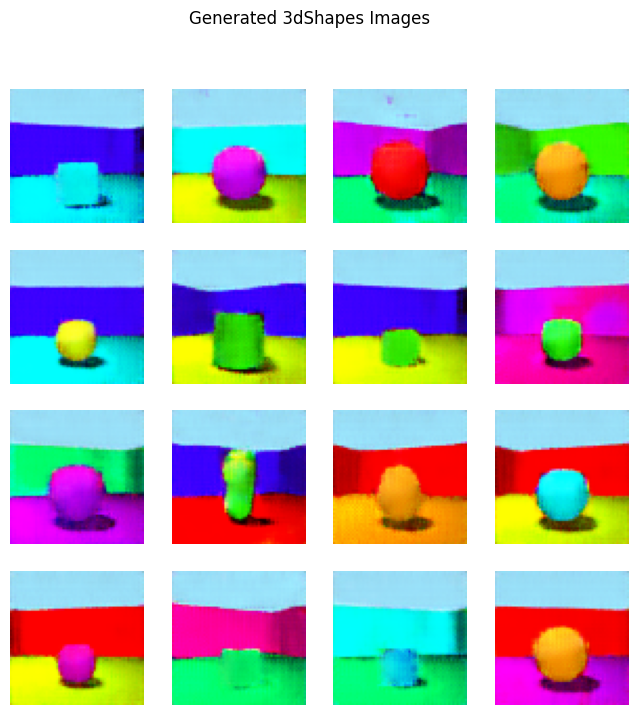

In [ ]:
visualize_generated_images(gen, gen.latent_dim, device, title="Generated 3dShapes Images")

## DSprites

In [73]:
# Load DSprites dataset
dsprites_img_size = (1, 64, 64)  # Single-channel images of size 64x64
DSprites = get_dataset("dsprites")

# dsprites_dataset = DSprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = DSprites(selected_factors=['color', 'shape', 'orientation', 'posX', 'posY'], not_selected_factors_index_value={'scale':5})


num_workers_dsprites = 4
dsprites_data_loader = DataLoader(dsprites_dataset, 
                                 batch_size=64, 
                                 shuffle=True, 
                                 num_workers=num_workers_dsprites, 
                                 pin_memory=True,
                                 persistent_workers=True
                                 )

In [43]:
# Initialize Generator and Discriminator for DSprites
dsprites_gen = Generator(dsprites_img_size, latent_dim=10, use_batchnorm=True).to(device)
dsprites_disc = SNDiscriminator(dsprites_img_size).to(device)

# Optimizers for DSprites models
dsprites_gen_optimizer = torch.optim.Adam(dsprites_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
dsprites_disc_optimizer = torch.optim.Adam(dsprites_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
dsprites_num_epochs = 50

print(f"DSprites Generator parameters: {sum(p.numel() for p in dsprites_gen.parameters() if p.requires_grad)}")
print(f"DSprites Discriminator parameters: {sum(p.numel() for p in dsprites_disc.parameters() if p.requires_grad)}")

DSprites Generator parameters: 381697
DSprites Discriminator parameters: 378049


In [44]:
# Train dSprites SN-GAN with WGAN loss
train_sn_gan(dsprites_gen, dsprites_disc, dsprites_gen_optimizer, dsprites_disc_optimizer, dsprites_data_loader, dsprites_num_epochs, device, dataset_name="dSprites", loss_type="hinge")

Starting dSprites SN-GAN Training with HINGE loss...


dSprites Epoch 50/50: 100%|██████████| 1920/1920 [00:13<00:00, 141.70it/s, D_Loss=0.943, G_Loss=-0.208]

dSprites training complete!


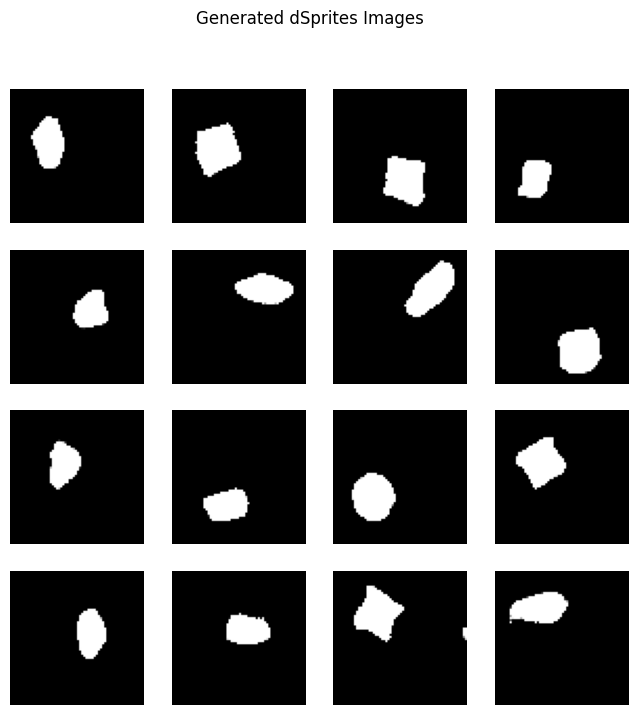

In [66]:
# Visualize generated images for dSprites
visualize_generated_images(dsprites_gen, dsprites_gen.latent_dim, device, title="Generated dSprites Images", is_grayscale=True)